# Python Demonstration Notebook
**By: Chris Wheelahan**<br>

This Python notebook is a compilation of a number of problems I completed as part of "Applied Computing 209a - Introduction to Data Science", taught at the Harvard Paulsen School of Engineering and Applied Sciences. These problems are selected to demonstrate my knowledge of python and some basic data science and machine learning concepts and algorithms. These are more-or-less as I submitted them when I took the class, although some effort has been made to contextualize the problems and clarify when needed.

### Import Libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import discriminant_analysis as da
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
from sklearn import preprocessing
from sklearn import svm
import sklearn.linear_model as sk
%matplotlib inline
from collections import Counter
import math

## Problem 1 - Sentiment analysis
In this problem, you will explore how to predict the underlying emotional tone of textual data - this task is called sentiment analysis. 

You will be using the dataset in the file `dataset_1.txt`. In this dataset, there are 1382 posts containing textual opinions about Ford automobiles, along with labels indicating whether the opinion expressed is positive or negative. 

Given a new post about an automobile, your goal is to predict if the sentiment expressed in the new post is positive or negative. For this task you should implement a *regularized* logistic regression model.

Produce a report summarizing your solution to this problem. Structure your presentation and exposition like a professional product that can be submitted to a client and or your supervisor at work.

### 1.1 Introduction

What we are being asked to do in this problem is look at a list of some ~1,400 reviews of Ford cars and create a model on this data that will predict whether a new review would be positive or negative. This is presumably so that we don't need to have someone do it manually. Sentiment analysis is an interesting issue with a comprehensive but still expanding body of literature around it. In the world of social media and digital content, companies and organizations are using sentiment analysis from Twitter, Facebook, and many other sources of digital content to target marketing and improve their products and services.

When thinking about this problem, it behooves us to think very clearly about exactly what data we have. Yes, we have the +/- sentiment, and we have the document descriptions... but what metadata do we have? The most important feature is the counts of each word appearing in our reviews. So that is what we can use to determine if a review is positive or negative.

What we will do in the following report is create a model with our sentiments as the "output" and counts of each important word appearing in the reviews as our inputs.

### 1.2 Data import and cleaning

In [2]:
#Import data and split into predictor and response (class and document)
data = pd.read_csv('datasets/dataset_1.txt')

#Split into predictor and response (text and sentiment)
sent = data[[0]]
text = data[[1]]

print data.head(n=5)
print data.tail(n=5)

sent.describe()

  class                                               text
0   Neg   In 1992 we bought a new Taurus and we really ...
1   Neg   The last business trip  I drove to San Franci...
2   Neg   My husband and I purchased a 1990 Ford F250 a...
3   Neg   I feel I have a thorough opinion of this truc...
4   Neg   AS a mother of 3  all of whom are still in ca...
     class                                               text
1377   Pos   In June we bought the Sony Limited Edition Fo...
1378   Pos   After 140 000 miles  we decided to replace my...
1379   Pos   The Ford Focus is a great little record setti...
1380   Pos   I needed a new car because my hyundai excel 9...
1381   Pos   The 2000 Ford Focus SE 4 door sedan has a spa...


,class
count,1382
unique,2
top,Pos
freq,691


### Data Import Results
The data here looks pretty clean. We have 1,382 entries (as expected) and the data is sorted by classification with negative comments first and positive comments after. We have 691 positive responses and 691 negative responses, so if we were to just randomly classify we would be right 50% of the time on average.

Thankfully, there are no special characters already, so that makes our job much easier - although it does look like some special characters have been turned into numerics. I'll strip those out. Presumably there shouldn't be any numbers that are common enough to make this a problem. The other thing I do want to do is to transform everything into lower-case, just to ease processing since Python is case-sensitive. Otherwise, I think we're good.

In [3]:
#Do relevant cleaning
text = text['text'].str.lower()

#I would do this part with Regular expressions, but the version we're using doesn't support it
text = text.str.replace('1', '')
text = text.str.replace('2', '')
text = text.str.replace('3', '')
text = text.str.replace('4', '')
text = text.str.replace('5', '')
text = text.str.replace('6', '')
text = text.str.replace('7', '')
text = text.str.replace('8', '')
text = text.str.replace('9', '')
text = text.str.replace('0', '')

### 1.3 Data Exploration

The first thing we need to do is get a sense of what words are important and what words are not. That is to say, which words show up a lot, and which don't. Also (and more importantly) which words show up a lot in positive reviews only, and which show up in negative reviews only.

What we'll do is create a list of the 1,000 "most important" words... 500 positve, and 500 negative.

In [4]:
#Create a counter of positive and negative word counts
pos_counts = Counter()
neg_counts = Counter()

for each in range(len(text)):
    if sent.iloc[each].all() == "Neg":
        string = text[each].split(" ")
        neg_counts += Counter(string)
    else:
        string = text[each].split(" ")
        pos_counts += Counter(string)
        
#Create a list of the 500 most important, negative words

#initialize variables
important_words = []
important_counts = []
negs = neg_counts.most_common()
pos_common = pos_counts.most_common(1000)
pos_index = []
pos_tally = []

#create a list of the 1,000 most important positive words
for i in range(len(pos_common)):
    pos_ind, pos_tal = pos_common[i]
    pos_index.append(pos_ind)
    pos_tally.append(pos_tal)

#for each word (in order of frequency in the negative reviews, and until we have a list of 500), check to see if
#it exists in our list of 1,000 important positive words
for i in range(len(negs)):
    neg_index, neg_count = negs[i]
    #if it's not in the positive words bank, and we don't have our list of 500 yet, add the word and count to a list
    if neg_index not in pos_index and len(important_words) < 500:
        important_words.append(neg_index)
        important_counts.append(neg_count)
        
#print len(important_words)
#print important_words[:10], important_counts[:10]

#Do the same for positive counts

#initialize variables
poss = pos_counts.most_common()
neg_common = neg_counts.most_common(1000)
neg_index = []
neg_tally = []

#create a list of the 1,000 most important negative words
for i in range(len(neg_common)):
    neg_ind, neg_tal = neg_common[i]
    neg_index.append(neg_ind)
    neg_tally.append(neg_tal)

#for each word (in order of frequency in the positive reviews, and until we have a list of 500), check to see if
#it exists in our list of 1,000 important negative words
for i in range(len(poss)):
    pos_index, pos_count = poss[i]
    #if it's not in the positive words bank, and we don't have our list of 500 yet, add the word and count to a list
    if pos_index not in neg_index and len(important_words) < 1000:
        important_words.append(pos_index)
        important_counts.append(pos_count)
        
#print len(important_words)
print "The fifteen most important negative words and their counts are: \n"
for cnt in range(15):
    print important_words[cnt],":", important_counts[cnt]
    
print "\nThe fifteen most important positive words and their counts are: \n"
for cnt in range(500, 515):
    print important_words[cnt],":", important_counts[cnt]

The fifteen most important negative words and their counts are: 

mechanic : 113
gasket : 104
broke : 102
rental : 98
recalls : 87
pump : 78
failed : 75
hate : 75
him : 75
worse : 74
unfortunately : 73
tried : 72
covered : 71
tempo : 69
happened : 69

The fifteen most important positive words and their counts are: 

towing : 87
highly : 76
trailer : 72
luxury : 70
haul : 68
gives : 68
adults : 67
svt : 66
hauling : 65
added : 64
wonderful : 63
cobra : 62
amp : 60
bags : 60
changes : 58


### 1.4 Data Modeling

So we have a pretty good idea of what words are important. Let's create a numpy array for the Positive/Negative (our outcome, as a boolean 0/1), and a matrix of X values including the count of a particular word in each entry.

In [5]:
#Create a NumPy array with the sentiment, positive and negative word counts for each entry
n = len(sent)
log_reg_X = np.empty([n, 1000])
log_reg_Y = np.empty([n, 1])
pos_neg = []

#Create a list of 0/1 for boolean values of Negative(0) or Positive(1)
for i in range(len(sent)):
    if sent.iloc[i, 0] == 'Neg':
        pos_neg.append(0)
    else:
        pos_neg.append(1)

#fill our nx1 outcomes matrix, and nx1000 features matrix
for j in range(text.shape[0]):
    log_reg_Y[j, 0] = pos_neg[j]
    string = text.iloc[j].split(' ')
   
    for k in range(len(important_words)):
        cnt = string.count(important_words[k])
        log_reg_X[j, k] = cnt

**Note:** Because we have a matrix of nearly 1,400 entries, and 1000 features, we have a very high chance of overfitting the data. What we'll do below is run a logistic regression with a regularization parameter tuned to different values. We'll then train a model on 80% of our data, and see how it does at predicting the other 20% of our data.

In [6]:
sub_size = int(n*.8) #25
perm = np.random.permutation(n)

#Create training and test sets 
x_train = log_reg_X[perm[:sub_size]]
y_train = np.ravel(log_reg_Y[perm[:sub_size]])
x_test = log_reg_X[perm[sub_size:]]
y_test = np.ravel(log_reg_Y[perm[sub_size:]])

#print x_train.shape, y_train.shape

#Run a logistic regression, and tune the regularization parameter
tuning_predictions = []
Cs = []

for i in range(-7, 8):
    predictions = []
    logitm_loop = sk.LogisticRegression(C = 10**i)
    fit = logitm_loop.fit(x_train, y_train)
    pred = fit.predict(x_test)

    for j in range(len(pred)):
        #print pred[j], log_reg_Y[j], pred[j] == log_reg_Y[j]
        if pred[j] == y_test[j]:
            predictions.append(1)
        else:
            predictions.append(0)

    correct = float(sum(predictions))/float(len(predictions))
    tuning_predictions.append(correct)
    Cs.append(10**i)

for length in range(len(Cs)):
    print "Percent Correct for regularization parameter of", Cs[length], "is", round(tuning_predictions[length], 4)

Percent Correct for regularization parameter of 1e-07 is 0.7653
Percent Correct for regularization parameter of 1e-06 is 0.7726
Percent Correct for regularization parameter of 1e-05 is 0.7726
Percent Correct for regularization parameter of 0.0001 is 0.7834
Percent Correct for regularization parameter of 0.001 is 0.7653
Percent Correct for regularization parameter of 0.01 is 0.7581
Percent Correct for regularization parameter of 0.1 is 0.7545
Percent Correct for regularization parameter of 1 is 0.7148
Percent Correct for regularization parameter of 10 is 0.6823
Percent Correct for regularization parameter of 100 is 0.6823
Percent Correct for regularization parameter of 1000 is 0.6643
Percent Correct for regularization parameter of 10000 is 0.6679
Percent Correct for regularization parameter of 100000 is 0.6426
Percent Correct for regularization parameter of 1000000 is 0.6318
Percent Correct for regularization parameter of 10000000 is 0.6354


### 1.5 Summary
What we see here is that, when you take into account the 500 most important positive and negative words, a regularized logistic regression with C = 0.01 seems most robust with a score of 78.3% correct. This is an okay result and shows that our model has some strength of predictability with regard to sentiment analysis; however, 78% reliability may not be adequate to make business decisions from. It would be important to discuss with the business owners of this project (presumably the marketing team) whether they feel comfortable using this data moving forward or if we should further tune our model with new data.

## Problem 2 - Automated Medical Diagnosis

In this problem, you are going to build a model to diagnose heart disease. 

The training set is provided in the file ``dataset_2_train.txt`` and there are two test sets: ``dataset_2_test_1.txt`` and ``dataset_2_test_2.txt``. Each patient in the datasets is described by 5 biomarkers extracted from cardiac SPECT images; the last column in each dataset contains the disease diagnosis (1 indicates that the patient is normal, and 0 indicates that the patient suffers from heart disease).

- Fit a logistic regression model to the training set, and report its accuracy on both the test sets. 


- Is your accuracy rate meaningful or reliable? How comfortable would you be in using your predictions to diagnose real living patients? Justify your answers. 


- Let's call the logistic regression model you learned, ${C}_1$. Your colleague suggests that you can get higher accuracies for this task by using a threshold of 0.05 on the Logistic regression model to predict labels instead of the usual threshold of 0.5, i.e. use a classifier that predicts 1 when $\widehat{P}(Y = 1\,|\, X) \geq 0.05$ and 0 otherwise. Let's call this classifier ${C}_2$. Does ${C}_2$ perform better the two test sets - that is, which one would you rather use for automated diagnostics? Support your conclusion with careful analysis. 


- Generalize your analysis of these two classifiers. Under what general conditions does $C_2$ perform better than ${C}_1$? Support your conclusion with a mathematical proof or simulation

### 1.1 Introduction
At first glance, this seems like a fairly simple classification problem. We'll take whatever data we have, run a logistic regression on our various features and hopefully be able to predict the presence or absence of heart disease. What makes this process interesting in this scenario is that diseases are generally rare conditions - found in 1% or in many cases much less of the population. 

A standard Bayes' classifier will assign a cutoff point for each prediction at p = 0.5, which is to say that if the model predicts a greater than 50% chance of having the disease, it will assign a positive prediction. This minimizes the classification error rate. In a rare event however, the probabilities will almost never be above 50% so all of our predictions will be "no disease".

This predictive model gives the best (lowest) classification error rate, but that is completely useless to us. We'll have to sacrifice true accuracy to try and predict these rare conditions. Let's see how we can do that...

### 1.2 Fit a Logistic Model and Report Outcomes

In [7]:
# A function that will return the Sensitivity, specificity, type I, and type II error rates
def get_accuracy(dis_pred, test_Y):
    correct_bool = []
    fp = []
    fn = []
    
    for each in range(len(dis_pred)):
        if dis_pred[each] == 1.0 and float(test_Y[each]) == 1.0:
            correct_bool.append(1)
            fp.append(0)
            fn.append(0)
        elif dis_pred[each] == 1.0 and float(test_Y[each]) == 0.0:
            correct_bool.append(0)
            fp.append(1)
            fn.append(0)
        elif dis_pred[each] == 0.0 and float(test_Y[each]) == 1.0:
            correct_bool.append(0)
            fp.append(0)
            fn.append(1)
        else:
            correct_bool.append(1)
            fp.append(0)
            fn.append(0)
            
    acc = float(sum(correct_bool))/float(len(correct_bool))
    fp_rate = float(sum(fp))/float(len(fp))
    fn_rate = float(sum(fn))/float(len(fn))

    prev = np.mean(dis_pred)
    
    return acc, prev, fp_rate, fn_rate

In [8]:
# Import and split our data
hd_data = pd.read_csv('datasets/dataset_2_train.txt')

disease = np.ravel(hd_data.iloc[:, -1:])
indicators = hd_data.iloc[:, :-1]

test1_data = pd.read_csv('datasets/dataset_2_test_1.txt')
disease_t1 = np.ravel(test1_data.iloc[:, -1:])
indicators_t1 = test1_data.iloc[:, :-1]

test2_data = pd.read_csv('datasets/dataset_2_test_2.txt')
disease_t2 = np.ravel(test2_data.iloc[:, -1:])
indicators_t2 = test2_data.iloc[:, :-1]

# Train a model and predict outcomes from our test sets
dis_log_reg = sk.LogisticRegression(C = 1000000)
dis_fit = dis_log_reg.fit(indicators, disease)
pred_t1 = dis_log_reg.predict(indicators_t1)
pred_t2 = dis_log_reg.predict(indicators_t2)

# Determine the accuracy of a logistic model on our test sets
t1_acc, t1_prev, t1_fp, t1_fn = get_accuracy(pred_t1, disease_t1)
t2_acc, t2_prev, t2_fp, t2_fn = get_accuracy(pred_t2, disease_t2)

print "The actual prevalence of the disease is", np.mean(disease), "\n"

print "*** TEST SET 1 ***"
print "The training model accuracy is", t1_acc
print "The predicted prevalence is", t1_prev
print "The false positive rate is", t1_fp
print "The false negative rate is", t1_fn, "\n"

print "*** TEST SET 2 ***"
print "The training model accuracy is", t2_acc
print "The predicted prevalence is", t2_prev
print "The false positive rate is", t2_fp
print "The false negative rate is", t2_fn, "\n"

The actual prevalence of the disease is 0.0516129032258 

*** TEST SET 1 ***
The training model accuracy is 0.939393939394
The predicted prevalence is 0.0
The false positive rate is 0.0
The false negative rate is 0.0606060606061 

*** TEST SET 2 ***
The training model accuracy is 0.494623655914
The predicted prevalence is 0.0
The false positive rate is 0.0
The false negative rate is 0.505376344086 



### Logistic Regression Results

What we see in this analysis is that in our predictions, our model is always predicting no-disease. This is not particularly surprising since it's a fairly uncommon occurrence in our dataset. Even in test set 2, which seems to have more observations with heart disease, our model continues to always predict "No heart disease".

In this case, our model is exactly as good as a model that always says "No heart disease", so our model is not particularly meaningful or useful. The other problem here is that, because you have a disease which it is critical to diagnose, we want to reduce our false-negative rate as much as possible. That's what we'll do next.

### 1.3 Fit a New Model with a lower Probability Threshold

In [9]:
# A function that manually performs a logistic regression and returns new predictions for a probability 
# threshold of 0.05
def custom_predictor(X_train, y_train, X_test):
    predictions = []
    correct_bool = []
    fp = []
    fn = []
    dis_log_reg = sk.LogisticRegression(C = 1000000)
    dis_fit = dis_log_reg.fit(X_train, y_train)

    for i in range(len(X_test)):
        exp = np.sum((X_test.iloc[i].values * dis_fit.coef_)) + dis_fit.intercept_
        pred = 1 / (1 + math.exp(-exp))
        if pred <= 0.05:
            predictions.append(1)
        else:
            predictions.append(0)
            
    return predictions

In [10]:
# generate new predictions for T1 and T2
new_pred_t1 = custom_predictor(indicators, disease, indicators_t1)
new_pred_t2 = custom_predictor(indicators, disease, indicators_t2)

# Determine the accuracy of a logistic model on our test sets
t1_acc, t1_prev, t1_fp, t1_fn = get_accuracy(new_pred_t1, disease_t1)
t2_acc, t2_prev, t2_fp, t2_fn = get_accuracy(new_pred_t1, disease_t2)

print "The actual prevalence of the disease is", np.mean(disease), "\n"

print "*** TEST SET 1 ***"
print "The training model accuracy is", t1_acc
print "The predicted prevalence is", t1_prev
print "The false positive rate is", t1_fp
print "The false negative rate is", t1_fn, "\n"

print "*** TEST SET 2 ***"
print "The training model accuracy is", t2_acc
print "The predicted prevalence is", t2_prev
print "The false positive rate is", t2_fp
print "The false negative rate is", t2_fn, "\n"

The actual prevalence of the disease is 0.0516129032258 

*** TEST SET 1 ***
The training model accuracy is 0.348484848485
The predicted prevalence is 0.651515151515
The false positive rate is 0.621212121212
The false negative rate is 0.030303030303 

*** TEST SET 2 ***
The training model accuracy is 0.530303030303
The predicted prevalence is 0.651515151515
The false positive rate is 0.409090909091
The false negative rate is 0.0606060606061 



### New Model Results
Essentially what we've done here is created a model which will much more often predict a positive result, in order to greatly reduce the number of false-negatives. We've done this because we've made a calculation that it's more important to reduce false-negatives than to have a few additional false-positives. This makes sense in disease diagnosis, because while a false positive may cause some anxiety, a false-negative could be deadly to the patient. This experiment demonstrates that result.

## Problem 3 - Image Processing

In this problem we revisit applications of classification, with the purpose of comparing the performance of support vector classifiers with other classifiers we have learned. We'll do this with the aeriel vegetation detection problem.

The data is contained in `dataset_3a.txt` and `dataset_3b.txt` (you are encouraged to use the datasets from Homework #7 as well). The first two columns of the data contains the latitude and longitudes of randomly sampled locations in the satellite image, and the last column contains a label indicating whether the location contains vegetation (1 denotes the presence of vegetation and 0 denotes otherwise). The task is to, again, identify the vegetation regions in the image.

- Compare the result of using support vector classifiers to perform classification against results obtained from other models you have learned. Which model is more appropriate for the general task of vegetation detection in aerial images (do not restrict yourself to which model performs better on just these two datasets)? Which model is more appropriate for other types of image processing (hand-writting digit classification for example) Your comparison should be both **qualitative** and quantitative.
    
- Are there any obvious draw backs to support vector classifiers as we have presented them to you? What might be some intuitive ways to address these draw backs?

### 3.1 Introduction

This problem is intended to emulate in a very basic way some of the complex image classification problems that data scientists work on. These problems are related to classifying satellite imagery, google maps images, photographs, etc. This problem however is very simple. The data is just X and Y (Latitude and Longitude) coordinates as the predictors, and a boolean 0/1 outcome for whether the observation is vegetation or not.

The purpose of this problem is to fit and compare a number of different potential classifiers so as to show which classifiers are good in which circumstances and which are not.

### 3.2 Import, Visualize, and Inspect Data

In [11]:
# A function that visualizes the data and the decision boundaries
def plot_decision_boundary(x, y, model, title, ax, bounds=(0, 1), poly_flag=False):
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='white')
    
    # Create mesh
    interval = np.arange(bounds[0], bounds[1], 0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
        
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

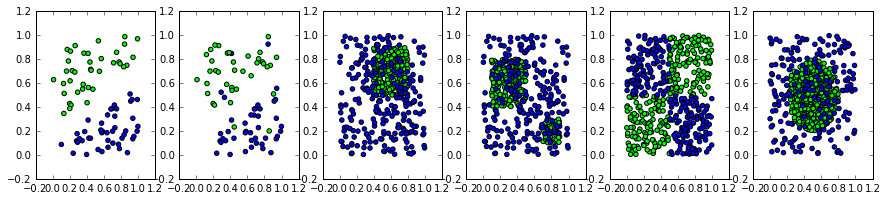

In [12]:
#Import data
img_1 = pd.read_csv('datasets/dataset_3a_test.txt', delimiter=',', header=None)
img_2 = pd.read_csv('datasets/dataset_3b_test.txt', delimiter=',', header=None)
img_3 = pd.read_csv('datasets/dataset_3c.txt', delimiter=',', header=None)
img_4 = pd.read_csv('datasets/dataset_3d.txt', delimiter=',', header=None)
img_5 = pd.read_csv('datasets/dataset_3e.txt', delimiter=',', header=None)
img_6 = pd.read_csv('datasets/dataset_3f.txt', delimiter=',', header=None)

image_list = [img_1, img_2, img_3, img_4, img_5, img_6]

n = len(image_list)

fig, ax = plt.subplots(1, n, figsize=(15, 3))
ax_ind = 0
plt.rcParams['image.cmap'] = 'brg'    


for each in range(len(image_list)):
    coords = image_list[each].iloc[:, :2]
    veg = image_list[each].iloc[:, -1]
        
    ax[ax_ind].scatter(image_list[each].iloc[:, 0], image_list[each].iloc[:, 1], c = image_list[each].iloc[:, 2])

    ax_ind += 1
plt.show()

### 3.3 Fit, tune and draw boundaries for several classifiers

In [13]:
#This function will fit, tune and draw the following:
# Polynomial Linear Regression
# Simple Logistic Regression
# Polynomial Logistic Regression
# Quadratic Discriminant Analysis
# Support Vector Classifier

def try_classifying(image_list):
    n = len(image_list)
    polylin_score = []
    log_score = []
    poly_log_score = []
    qda_score = []
    svm_score = []
    best_Cs = []

    #Instantiate our charts
    fig2, ax2 = plt.subplots(n, 5, figsize=(36, 28))
    plt.rcParams['image.cmap'] = 'brg' 
    
    #Loop over our images
    for images in range(len(image_list)):
        ax_ind = 0
        #split into regressors and outcomes
        coords = image_list[images].iloc[:, :2]
        veg = image_list[images].iloc[:, -1]
        
#        print coords.head(n=3)
#        print veg.head(n=3)
        
        #***Polynomial regression***
        poly_lin_subscore = []
        #Check best fit for polynomials 2-9
        for exp in range(2, 10):
            coords_sq = coords**exp
            poly_reg = LinearRegression()
            poly_reg_model = poly_reg.fit(coords_sq, veg)
            score = poly_reg.score(coords_sq, veg)
            poly_lin_subscore.append(score)
            
        coords_sq = coords**(poly_lin_subscore.index(max(poly_lin_subscore)) + 2)
        
        #Create best model
        poly_reg = LinearRegression()
        poly_reg_model = poly_reg.fit(coords_sq, veg)
        polylin_score.append(poly_reg.score(coords_sq, veg))
        
        #Draw decision boundary
        plot_decision_boundary(coords_sq.values, veg.values, poly_reg_model, "Poly Regression Boundaries", ax2[images, ax_ind])
        ax_ind += 1

        #***Simple Logistic Regression***
        log_reg = linear_model.LogisticRegression()
        log_reg_model = log_reg.fit(coords, veg)
        plot_decision_boundary(coords.values, veg.values, log_reg_model, "Logistic Regresion Boundaries", ax2[images, ax_ind])
        ax_ind += 1
        log_score.append(log_reg.score(coords, veg))

        
        #***Poly Logistic Regression***
        poly_log_subscore = []
        
        #Check best fit for polynomials 2-9
        for exp in range(2, 10):
            coords_sq = coords**exp
            log_reg2 = linear_model.LogisticRegression()
            log_reg_model2 = log_reg2.fit(coords_sq, veg)
            score = log_reg2.score(coords_sq, veg)
            poly_log_subscore.append(score)
            
        #Create best model
        log_reg2 = linear_model.LogisticRegression()
        coords_sq = coords**(poly_log_subscore.index(max(poly_log_subscore)) + 2)
        log_reg_model2 = log_reg2.fit(coords_sq, veg)
        
        #draw decision boundary
        plot_decision_boundary(coords_sq.values, veg.values, log_reg_model2, "Polynomial Logistic Boundaries", ax2[images, ax_ind])
        ax_ind += 1
        poly_log_score.append(log_reg2.score(coords_sq, veg))
        
        #***QDA***
        QDA = da.QuadraticDiscriminantAnalysis()
        QDA_model = QDA.fit(coords, veg)
        plot_decision_boundary(coords.values, veg.values, QDA_model, "QDA Decision Boundaries", ax2[images, ax_ind])
        ax_ind += 1
        qda_score.append(QDA.score(coords, veg))
        
        #***SVM***
        svm_subscore = []

        #Check best fit for tuning parameters
        for exp in range(-7, 8):
            C = 10**exp
            SVM = svm.SVC(C=C, kernel='linear')
            svm_model = SVM.fit(coords, veg)
            score = SVM.score(coords, veg)
            svm_subscore.append(score)
            
        #Create best model
        best_C = 10** (svm_subscore.index(max(svm_subscore)) - 7)
        best_Cs.append(best_C)
        svm_best = svm.SVC(C=best_C, kernel='linear')
        best_svm_model = svm_best.fit(coords, veg)
        
        #draw decision boundary
        plot_decision_boundary(coords.values, veg.values, best_svm_model, "SVM Decision Boundaries", ax2[images, ax_ind])
        ax_ind += 1
        svm_score.append(svm_best.score(coords, veg))
    
    plt.show()
    
    for j in range(len(image_list)):
        print "Scores for Dataset", j+1, "are: \n", 
        print "----------------------------------------"
        print "Polynomial linear regression:", round(polylin_score[j], 3), "\n", 
        print "Simple logisitc regression:", round(log_score[j], 3), "\n",
        print "Polynomial logistic regression:", round(poly_log_score[j], 3), "\n",
        print "QDA:", round(qda_score[j], 3)
        print "SVM:", round(svm_score[j], 3), "(penalty C =", best_Cs[j], ")"
        print "----------------------------------------"
        

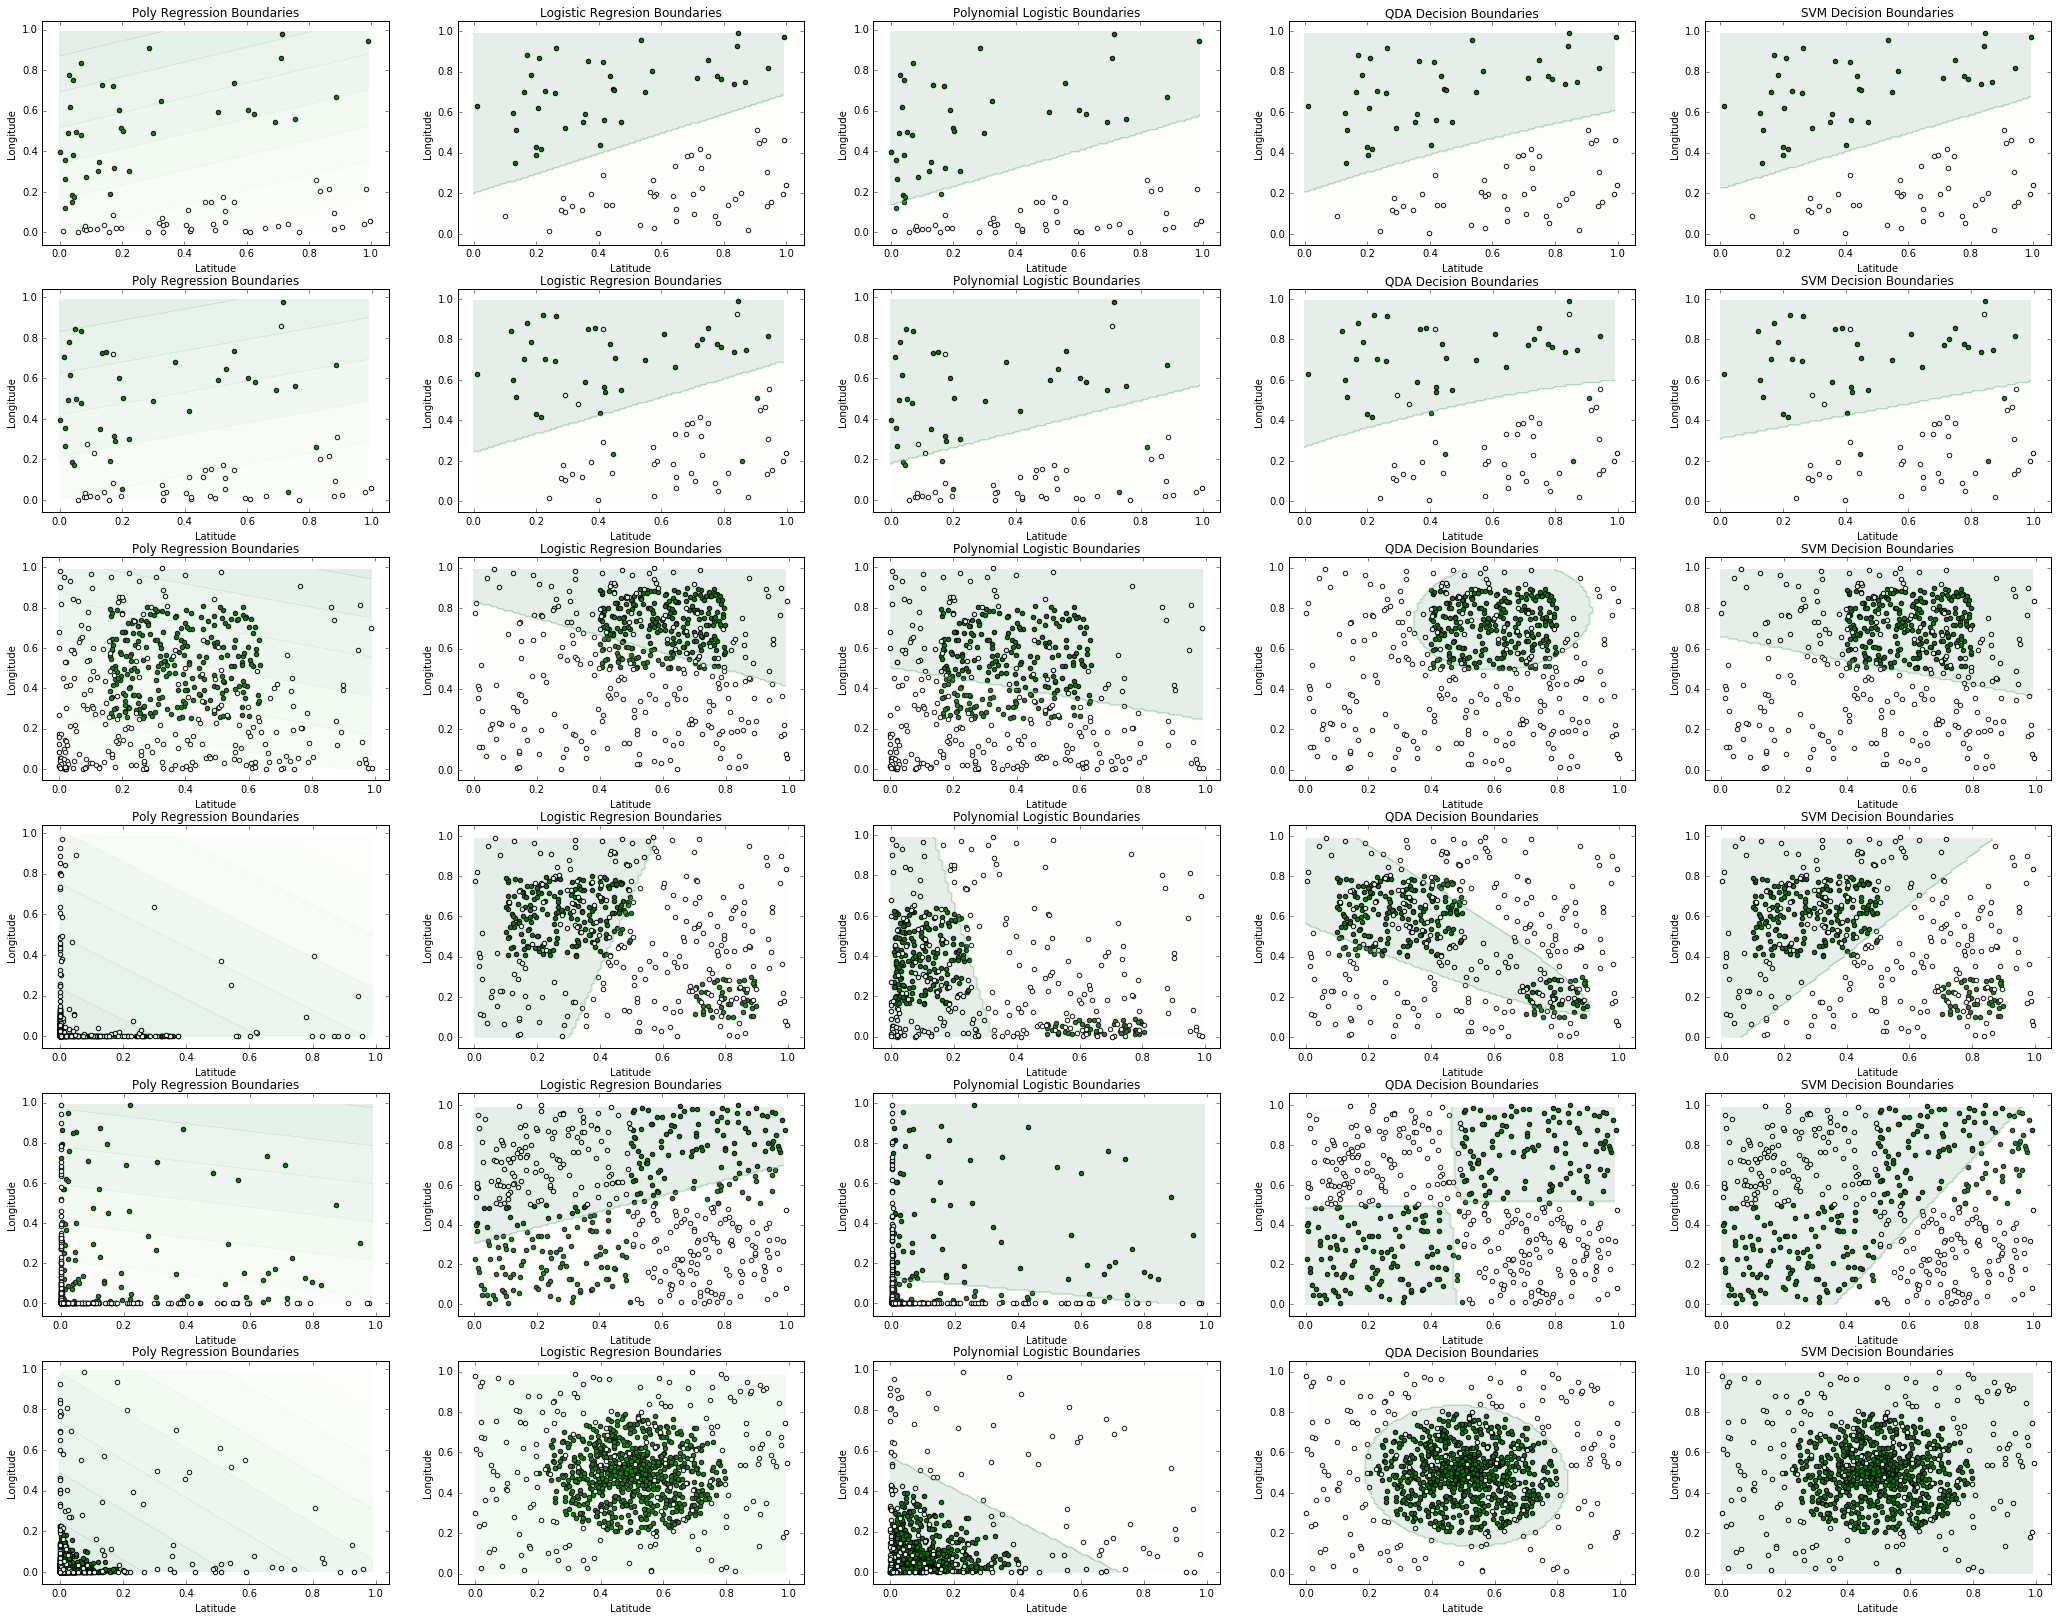

Scores for Dataset 1 are: 
----------------------------------------
Polynomial linear regression: 0.763 
Simple logisitc regression: 1.0 
Polynomial logistic regression: 0.964 
QDA: 1.0
SVM: 1.0 (penalty C = 1 )
----------------------------------------
Scores for Dataset 2 are: 
----------------------------------------
Polynomial linear regression: 0.535 
Simple logisitc regression: 0.912 
Polynomial logistic regression: 0.875 
QDA: 0.9
SVM: 0.912 (penalty C = 1 )
----------------------------------------
Scores for Dataset 3 are: 
----------------------------------------
Polynomial linear regression: 0.169 
Simple logisitc regression: 0.724 
Polynomial logistic regression: 0.684 
QDA: 0.87
SVM: 0.756 (penalty C = 0.1 )
----------------------------------------
Scores for Dataset 4 are: 
----------------------------------------
Polynomial linear regression: 0.084 
Simple logisitc regression: 0.664 
Polynomial logistic regression: 0.65 
QDA: 0.73
SVM: 0.67 (penalty C = 10000000 )
--------

In [14]:
try_classifying(image_list)

### 3.4 Fit Decision Tree classifiers
In addition to the classifiers we have explored above, this assignment was intended to give more insight into Decision Trees. Below, we have fit a decision tree classifier of several depths to the data.

In [15]:
#--------  fit_and_plot_dt
# Fit decision tree with on given data set with given depth, and plot the data/model
# Input: 
#      fname (string containing file name)
#      depth (depth of tree)

def fit_and_plot_dt(x, y, depth, title, ax):
    # FIT DECISION TREE MODEL
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(x, y)

    # PLOT DECISION TREE BOUNDARY
    ax = plot_tree_boundary(x, y, dt, title, ax)
    
    return ax

#--------  plot_tree_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (array of predictors)
#      y (array of labels)
#      model (the decision tree you want to visualize, already fitted)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_tree_boundary(x, y, model, title, ax):
    # PLOT DATA
    ax.scatter(x[y==1,0], x[y==1,1], c='green')
    ax.scatter(x[y==0,0], x[y==0,1], c='white')
    
    # CREATE MESH
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

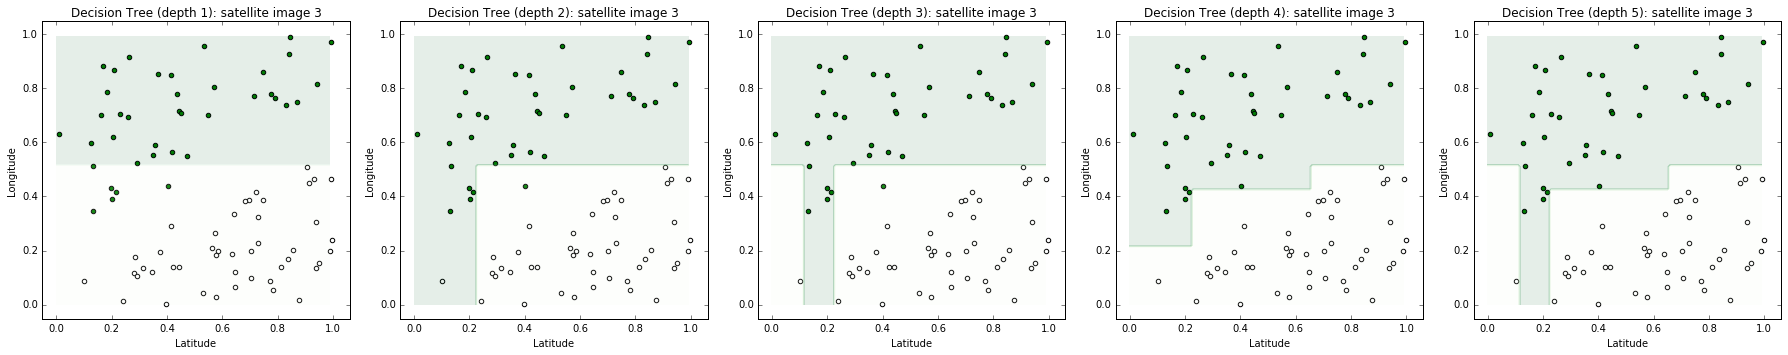

Tree Scores for Dataset 1 by depth are:
----------------------------------------
A tree of depth 1 is 0.94 percent accurate.
A tree of depth 2 is 0.976 percent accurate.
A tree of depth 3 is 0.988 percent accurate.
A tree of depth 4 is 1.0 percent accurate.
A tree of depth 5 is 1.0 percent accurate.


In [16]:
# Plot for dataset_1.txt: depths 1 to 5
fig3, ax3 = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))
#Get the long/lat coords
x = image_list[0].values[:, :-1]
#Get the class labels
y = image_list[0].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax3[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 3'.format(i), ax3[ind]) 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()


print "Tree Scores for Dataset 1 by depth are:" 
print "----------------------------------------"
for each in range(1, 6):
    dt = tree.DecisionTreeClassifier(max_depth = each)
    dt.fit(x, y)
    print "A tree of depth", each, "is", round(dt.score(x, y), 3), "percent accurate."

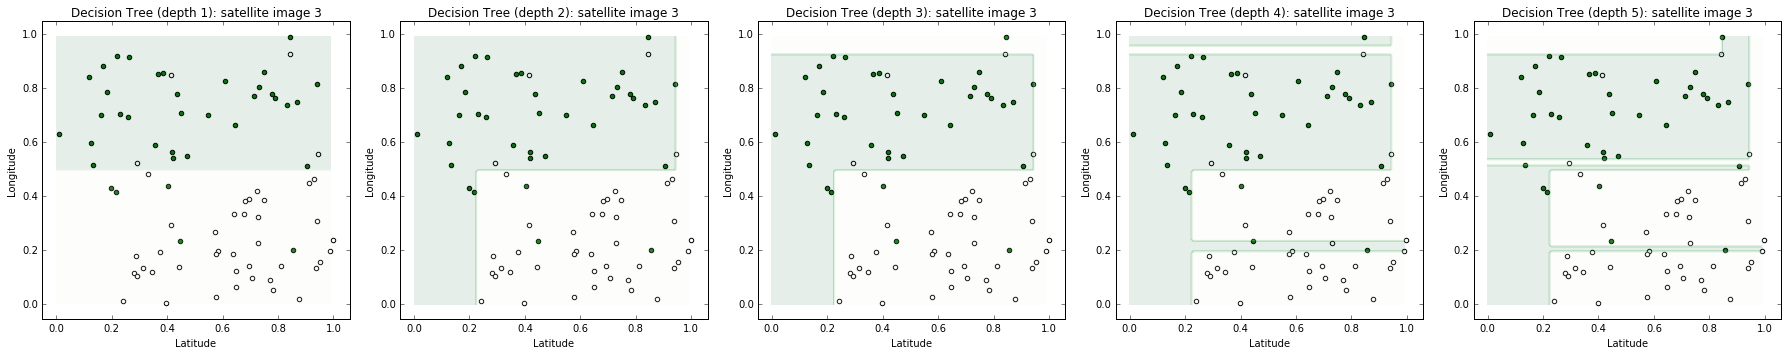

Tree Scores for Dataset 1 by depth are:
----------------------------------------
A tree of depth 1 is 0.887 percent accurate.
A tree of depth 2 is 0.925 percent accurate.
A tree of depth 3 is 0.925 percent accurate.
A tree of depth 4 is 0.95 percent accurate.
A tree of depth 5 is 0.963 percent accurate.


In [17]:
# Plot for dataset_2.txt: depths 1 to 5
fig3, ax3 = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))
#Get the long/lat coords
x = image_list[1].values[:, :-1]
#Get the class labels
y = image_list[1].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax3[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 3'.format(i), ax3[ind]) 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()


print "Tree Scores for Dataset 1 by depth are:" 
print "----------------------------------------"
for each in range(1, 6):
    dt = tree.DecisionTreeClassifier(max_depth = each)
    dt.fit(x, y)
    print "A tree of depth", each, "is", round(dt.score(x, y), 3), "percent accurate."

### 3.5 Analysis

So which of our methodologies is best for remote sensing? My assessment is that the best tool, in general, would be decision trees. While some methodologies may perform better than trees in particular circumstances, the trees provide the most flexibility in classifying small/abnormal clusters and shapes of vegetation inside our images.

Thinking of another image classification problem, like the hand written numbers problem we had earlier in the semester, I don't believe that SVC would be the best methodology. SVC ultimately creates a differentiator of dimension p-1 where p is the number of classifiers in our dataset. So in the case of an 8x8 image, we have 64 pixels worth of data... SVC would create a differentiator of 63 dimensions, where really what we're looking for are the one or few dimensions of greatest differentiation. This is why we used PCA for that task - because that's exactly what it does.

Trees build new leaves based on what classifiers offer the greatest differentiation, so they may work well but will need to be tuned properly to prevent overfitting.

When thinking about other image classifications, like hand-written numbers, it ultimately comes down to the ultimate Data Scientist's answer - it depends. It depends on what kind of data you have, it depends on how good the data is, and - most importantly - it depends ultimately on what you are trying to do. Trees work well for the kind of classification in this problem and given our data; however, what if we were given X and Y coordinates, colors for each pixel in an image, and data from 37 sensors in 10 different satellites? And what if we were given all of this data many times to depict many different passes from a sattelite? This suddenly becomes a whole different issue and we have several questions to answer in addition to simply "is this vegetation or not?" A data scientist must look at what data s/he has and make informed decisions on what methods to apply and how.

SVCs have, in my mind, a few key disadvantages. First, SVM is simply VERY computationally taxing on a large test set, as I discovered doing this homework set. It takes forever. Secondly, it is not well researched in using multi-class classification. One solution would be to use SVM to create $\binom nk$ binary classifiers and use a majority vote to decide on a class, but given the performance issues noted above, that may be impractical.